In [1]:
import os
import json
import argparse
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from cycler import cycler
from pathlib import Path
from coffea import processor
from intervals import poisson_interval, ratio_uncertainty
from report import build_report
from histograms import ttbar_cr_histograms
from processor_utils import (
    group_outputs,
    accumulate_outputs,
    fill_histograms,
    get_lumiweights,
    scale_histograms,
    group_histograms,
    get_mc_error,
)
np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
output_directory = "../../outfiles/CR1_skimmer/2023-06-20/ttbar_cr1_skimmer/2017/mu"

In [3]:
# load cross sections
main_path = Path.cwd().parent.parent
with open(f"{main_path}/wprime_plus_b/data/DAS_xsec.json", "r") as f:
    xsecs = json.load(f)
# define luminosity
lumi = 41477.877399

In [4]:
# group and accumulate outputs
grouped_outputs = group_outputs(output_directory)
accumulated_outputs = accumulate_outputs(grouped_outputs)

In [5]:
# fill hist histograms with output arrays
hist_histograms = ttbar_cr_histograms
histograms = fill_histograms(accumulated_outputs, hist_histograms)

In [6]:
# scale histograms to lumi-xsec
lumi_weights = get_lumiweights(accumulated_outputs, xsecs, lumi)
scaled_histograms = scale_histograms(histograms, lumi_weights)

In [7]:
# group scale histograms by process
grouped_histograms = group_histograms(scaled_histograms)

In [8]:
# get mc errors
mc_errors = get_mc_error(accumulated_outputs, ttbar_cr_histograms, xsecs, lumi)

In [9]:
build_report(accumulated_outputs, xsecs, lumi)

,events,percentage,error
DYJetsToLL,4752.504991,0.643439,65.283666
WJetsToLNu,21677.211549,2.934867,210.680662
VV,939.654258,0.127219,20.370035
tt,661347.169261,89.539455,225.389937
SingleTop,49740.0097,6.734275,159.18057
Higgs,153.223727,0.020745,24.589983
Data,691680,NaN,831.673013
Total bkg,738609.773486,NaN,354.692799
Data/bkg,0.936462,NaN,0.001212


In [10]:
label_map = {
    "ele": {
        "jet_pt": r"$p_T$(b-Jet$_{0}$) [GeV]",
        "jet_eta": r"$\eta$(b-Jet$_{0}$)",
        "jet_phi": r"$\phi$(b-Jet$_{0}$)",
        "met": r"$p_T^{miss}$ [GeV]",
        "met_phi": r"$\phi(p_T^{miss})$",
        "lepton_pt": r"$p_T(e)$ [GeV]",
        "lepton_relIso": "$e$ RelIso",
        "lepton_eta": r"$\eta(e)$",
        "lepton_phi": r"$\phi (e)$",
        "lepton_bjet_mass": r"$m(e, $b-Jet$_{0})$ [GeV]",
        "lepton_bjet_dr": r"$\Delta R$($e$, b-Jet$_{0}$)",
        "lepton_met_mass": r"$m_T$($e$, $p_T^{miss}$) [GeV]",
        "lepton_met_delta_phi": r"$\Delta \phi(e, p_T^{miss})$",
        "lepton_met_bjet_mass": r"$m_T^{tot}(e, $b-Jet$_{0}, p_T^{miss})$ [GeV]",
    },
    "mu": {
        "jet_pt": r"$p_T$(b-Jet$_{0}$) [GeV]",
        "jet_eta": r"$\eta$(b-Jet$_{0}$)",
        "jet_phi": r"$\phi$(b-Jet$_{0}$)",
        "met": r"$p_T^{miss}$ [GeV]",
        "met_phi": r"$\phi(p_T^{miss})$",
        "lepton_pt": r"$p_T(\mu)$ [GeV]",
        "lepton_relIso": "$\mu$ RelIso",
        "lepton_eta": r"$\eta(\mu)$",
        "lepton_phi": r"$\phi (\mu)$",
        "lepton_bjet_mass": r"$m(\mu, $b-Jet$_{0})$ [GeV]",
        "lepton_bjet_dr": r"$\Delta R$($\mu$, b-Jet$_{0}$)",
        "lepton_met_mass": r"$m_T$($\mu$, $p_T^{miss}$) [GeV]",
        "lepton_met_delta_phi": r"$\Delta \phi(\mu, p_T^{miss})$",
        "lepton_met_bjet_mass": r"$m_T^{tot}(\mu, $b-Jet$_{0}, p_T^{miss})$ [GeV]",
    },
}
sample_map = {
    "VV": "VV",
    "SingleTop": "Single Top",
    "WJetsToLNu": r"W$(\ell \nu)$+jets",
    "tt": r"$t\bar{t}$",
    "DYJetsToLL": r"DY$(\ell\ell)$+jets",
    "Higgs": "Higgs",
    "SingleMuon": "Data",
    "SingleElectron": "Data",
}
mc_hist_kwargs = {
    "histtype": "fill",
    "stack": True,
    "sort": "yield",
    "linewidth": 0.7,
    "edgecolor": "k",
}
data_hist_kwargs = {
    "histtype": "errorbar",
    "color": "k",
    "linestyle": "none",
    "marker": ".",
    "markersize": 7.0,
    "elinewidth": 1,
    "yerr": True,
    "xerr": True,
    "linestyle": "none",
    "marker": ".",
}
errps = {
    "hatch": "////",
    "facecolor": "none",
    "lw": 0,
    "color": "k",
    "edgecolor": "k",
    "alpha": 0.6,
}

def plot_histogram(
    histograms: dict,
    kin: str,
    var: str,
    mc_errors: dict = None,
    channel: str = "mu",
    output_dir: str = None,
) -> None:
    """
    plot mc and data histograms. include data/bkg ratio plot

    Parameters:
    -----------
    histograms:
        dictionary with hist histograms to plot
    kin:
        key of the n-dimensional hist histogram
        {'jet_kin', 'lepton_kin', 'met_kin', 'lepton_met_kin', 'lepton_bjet_kin', 'lepton_met_bjet_kin'}
    var:
        variable to plot
    mc_errors:
        dictionary with mc error by sample. If None, the 'poisson_interval' function is used
    channel:
        lepton channel {'mu', 'ele'}
    output_dir:
        name of the directory to save the figure
    """
    # set style and some plotting params
    hep.style.use(hep.style.CMS)
    plt.rcParams.update(
        {
            "font.size": 12,
            "axes.titlesize": 12,
            "axes.labelsize": 12,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
            "lines.markersize": 3,
            "legend.fontsize": 10,
        }
    )
    plt.rcParams["axes.prop_cycle"] = cycler(
        color=[
            "tab:olive",
            "tab:red",
            "tab:green",
            "tab:orange",
            "tab:blue",
            "tab:purple",
        ]
    )
    # get mc and data hists. get labels for mc
    mc_labels, mc_histos = [], []
    for sample, values in histograms.items():
        if values is None:
            continue
        if sample == "Data":
            data_hist = values[kin].project(var)
        else:
            mc_labels.append(sample_map[sample])
            mc_histos.append(values[kin].project(var))
    # define figure and axes for histograms (ax) and ratio plot (rax)
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(5, 5),
        tight_layout=True,
        gridspec_kw={"height_ratios": (5, 1)},
        sharex=True,
    )
    # -----------------------
    # mc and data histograms
    # -----------------------
    # plot mc and data histograms
    hep.histplot(mc_histos, label=mc_labels, ax=ax, **mc_hist_kwargs)
    hep.histplot(data_hist, label="Data", ax=ax, **data_hist_kwargs)

    # get histogram's edges and centers
    total_mc = processor.accumulate(mc_histos)
    edges = total_mc.axes.edges[0]
    centers = total_mc.axes.centers[0]

    # get mc uncertaity interval
    mc_values = total_mc.values()
    mc_variances = total_mc.variances()
    if mc_errors is None:
        mc_error_down, mc_error_up = poisson_interval(
            values=mc_values, variances=mc_variances
        )
    else:
        mc_error = mc_errors[kin][var]
        mc_error_down = mc_values - mc_error
        mc_error_up = mc_values + mc_error
    # plot mc uncertaity interval
    ax.stairs(
        values=mc_error_up,
        baseline=mc_error_down,
        edges=edges,
        label="Stat. unc.",
        **errps,
    )
    # set axes labels and legend. change legend layout for any distribution with 'eta' or 'phi'
    ncols = 1
    if ("eta" in var) or ("phi" in var):
        ncols = 3
        ylim = ax.get_ylim()[1]
        ax.set_ylim(0, ylim + 0.4 * ylim)
        ax.legend(loc="upper center", ncol=ncols)
    else:
        ax.legend(loc="upper right", ncol=ncols)
    ax.set(
        xlabel=None,
        ylabel="Events",
    )
    # set lumi and CMS text
    hep.cms.lumitext("41.5 fb$^{-1}$ (2017, 13 TeV)", fontsize=9, ax=ax)
    hep.cms.text("Preliminary", ax=ax)

    # --------------------
    # data/bkg ratio plot
    # --------------------
    # get data/bkg ratio and uncertaity interval
    data_values = data_hist.values()
    numerator = data_values
    denominator = mc_values
    error_down, error_up = ratio_uncertainty(
        num=numerator, denom=denominator, uncertainty_type="poisson"
    )
    ratio = numerator / denominator
    ratio_error_up = ratio + error_up
    ratio_error_down = ratio - error_down

    # plot data to bkg ratio
    xerr = edges[1:] - edges[:-1]
    rax.errorbar(
        x=centers,
        y=ratio,
        xerr=xerr / 2,
        fmt="ko",
    )
    # plot data/bkg uncertaity interval
    rax.vlines(centers, ratio_error_down, ratio_error_up, color="k")
    ratio_uncertainty_band = rax.fill_between(
        edges[1:],
        ratio_error_up,
        ratio_error_down,
        step="pre",
        color="none",
        hatch="////",
        alpha=0.6,
        edgecolor="k",
        linewidth=0,
    )
    # get ratio plot y-limits
    up_limit = np.nanmax(ratio_error_up)
    down_limit = np.nanmin(ratio_error_down)
    scale = 1.1
    yup = scale * up_limit
    ydown = down_limit - scale * (1 - down_limit)
    
    up_distance = abs(up_limit - 1)
    down_distance = abs(down_limit - 1)
    if up_distance > 2 * down_distance:
        ydown = 1 - up_distance
          
    # set ratio plot labels, limits and facecolor
    rax.set(
        xlabel=label_map[channel][var],
        ylabel="Data/Bkg",
        ylim=(ydown, yup),
        facecolor="white",
    )
    # set ratio plot y-label size
    rax.yaxis.label.set_size(10)

    # plot horizontal line at y=1
    rax.hlines(1, *rax.get_xlim(), color="k", linestyle=":")

    # save figure
    if output_dir is None:
        fname = f"{channel}_{var}"
    else:
        fname = f"{output_dir}/{channel}_{var}"
    plt.show()

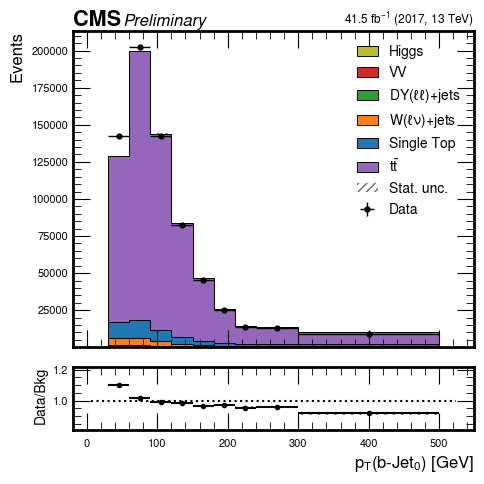

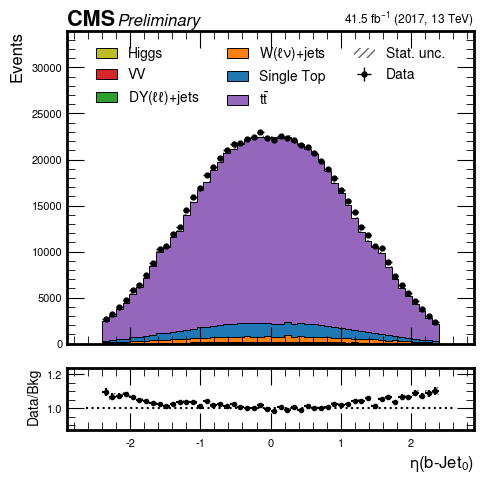

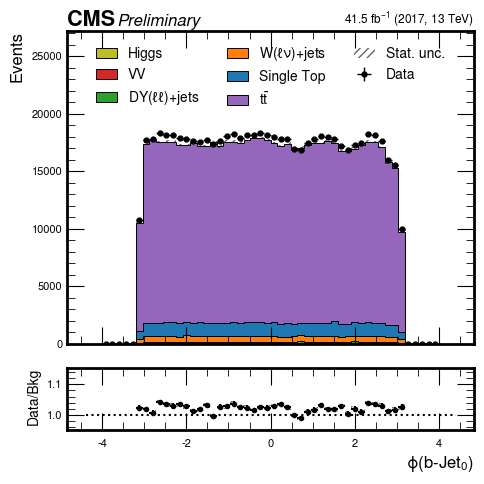

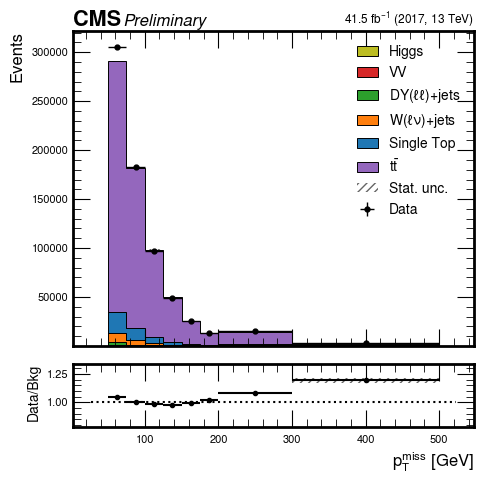

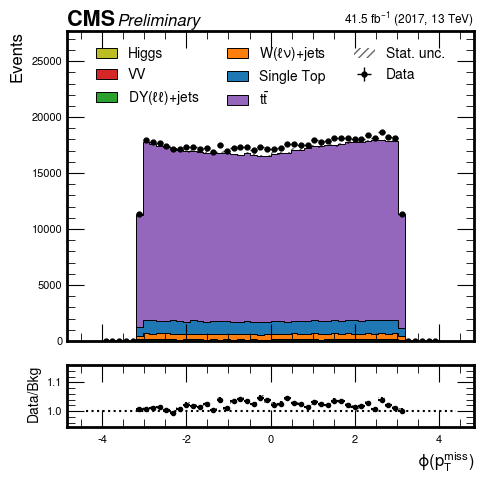

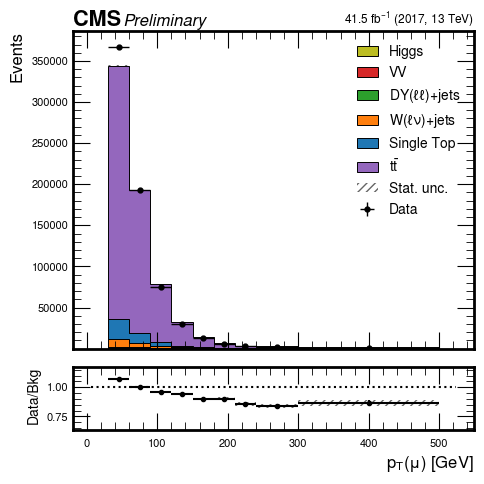

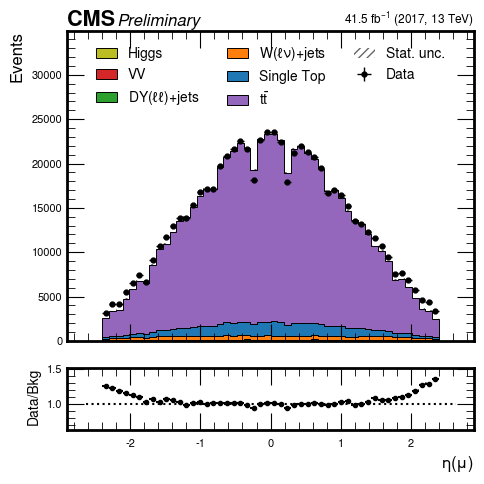

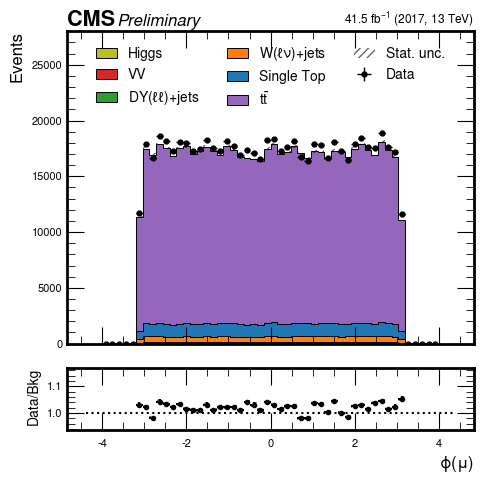

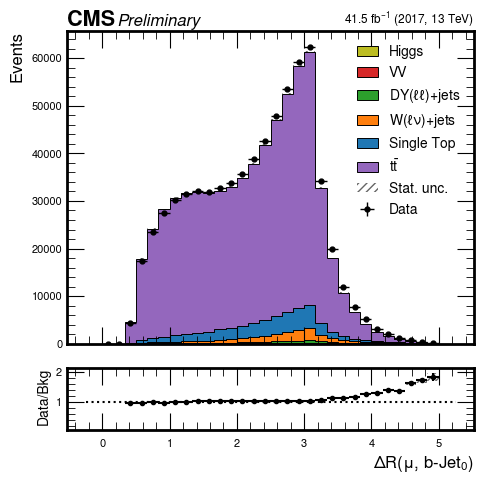

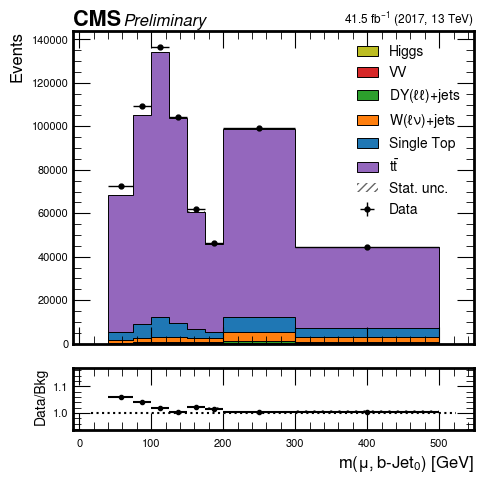

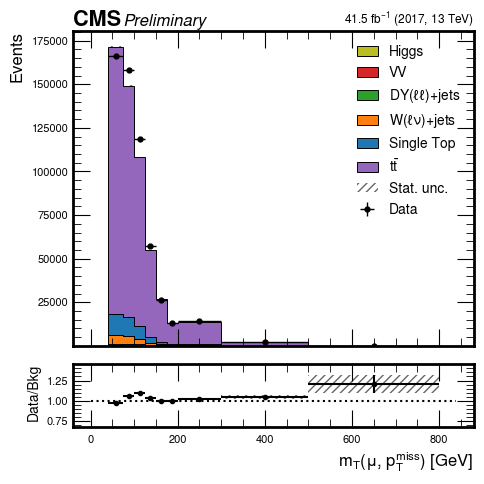

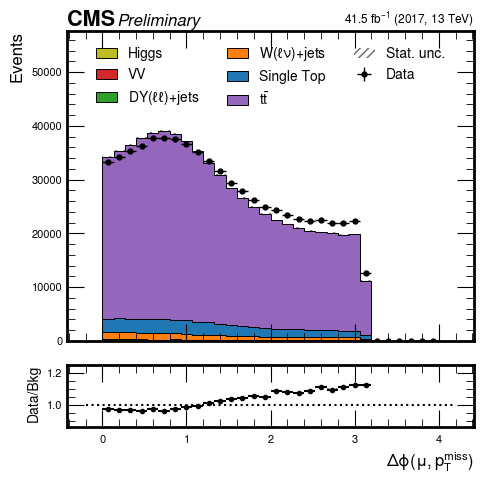

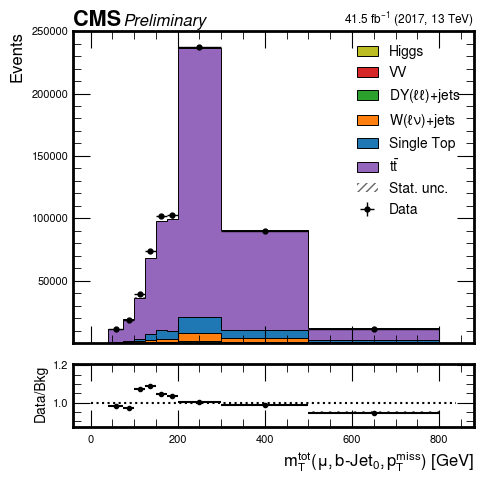

In [11]:
for sample in grouped_histograms:
    for kin in grouped_histograms[sample]:
        for var in grouped_histograms[sample][kin].axes.name:
            plot_histogram(
                histograms=grouped_histograms,
                kin=kin,
                var=var,
                mc_errors=mc_errors,
                channel="mu",
            )
    break